In [1]:
import os
import pandas as pd
import json
import glob


In [2]:
# os.getcwd()

In [4]:
# os.listdir('webhooks')

In [6]:
# import pandas as pd
# import json
# import glob
# import os
# from datetime import datetime
# 
# def read_json_file(filepath):
#     records = {}
#     common_fields = ['from', 'to', 'uuid', 'conversation_uuid', 'direction']
# 
#     with open(filepath, 'r') as file:
#         content = file.read()
#         json_strings = content.strip().split('}\n{')
# 
#         for i, json_str in enumerate(json_strings):
#             if i > 0:
#                 json_str = '{' + json_str
#             if i < len(json_strings) - 1:
#                 json_str = json_str + '}'
# 
#             try:
#                 record = json.loads(json_str)
#                 conv_id = record['conversation_uuid']
# 
#                 # Initialize record if first time seeing this conversation
#                 if conv_id not in records:
#                     records[conv_id] = {field: record[field] for field in common_fields}
#                     records[conv_id]['timestamps'] = {}
#                     records[conv_id]['status_sequence'] = []
#                     records[conv_id]['sub_states'] = []
#                     # Initialize detection fields
#                     records[conv_id]['detection_timestamp'] = None
#                     records[conv_id]['detection_type'] = None
# 
#                 # Add timestamp with associated status
#                 status = record.get('status')
#                 if status:
#                     records[conv_id]['timestamps'][status] = record['timestamp']
#                     records[conv_id]['status_sequence'].append(status)
#                     
#                     # Capture machine/human detection ONLY on first occurrence
#                     if status == 'machine' and records[conv_id]['detection_type'] is None:
#                         records[conv_id]['detection_timestamp'] = record['timestamp']
#                         records[conv_id]['detection_type'] = 'machine'
#                     elif status == 'human' and records[conv_id]['detection_type'] is None:
#                         records[conv_id]['detection_timestamp'] = record['timestamp']
#                         records[conv_id]['detection_type'] = 'human'
# 
#                 # Add sub_state if present
#                 if 'sub_state' in record:
#                     records[conv_id]['sub_states'].append(record['sub_state'])
# 
#                 # Add any unique fields from completion record
#                 if status == 'completed':
#                     unique_fields = ['end_time', 'network', 'duration', 'disconnected_by',
#                                      'start_time', 'rate', 'price']
#                     for field in unique_fields:
#                         if field in record:
#                             records[conv_id][field] = record[field]
# 
#             except json.JSONDecodeError:
#                 continue
# 
#     return records
# 
# def calculate_detection_intervals(all_records):
#     """Calculate detection intervals after all records are loaded"""
#     for conv_id, record in all_records.items():
#         answered_time = record['timestamps'].get('answered')
#         detection_time = record.get('detection_timestamp')
#         
#         if answered_time and detection_time:
#             try:
#                 # Convert timestamps to datetime objects for calculation
#                 answered_dt = datetime.fromisoformat(answered_time.replace('Z', '+00:00'))
#                 detection_dt = datetime.fromisoformat(detection_time.replace('Z', '+00:00'))
#                 
#                 # Calculate interval in seconds
#                 interval = (detection_dt - answered_dt).total_seconds()
#                 record['detection_interval_seconds'] = interval
#                 
#             except (ValueError, TypeError) as e:
#                 print(f"Error calculating interval for {conv_id}: {e}")
#                 record['detection_interval_seconds'] = None
#         else:
#             record['detection_interval_seconds'] = None
#     
#     return all_records
# 
# def read_webhooks_from_directories(base_path, directories):
#     '''Read webhook files from multiple directories and combine them'''
#     all_records = {}
# 
#     for directory in directories:
#         directory_path = os.path.join(base_path, directory)
# 
#         # Check if directory exists
#         if not os.path.exists(directory_path):
#             print(f'Warning: Directory {directory_path} does not exist... skipping.')
#             continue
# 
#         # Find all json files in this directory
#         json_files = glob.glob(os.path.join(directory_path, '*.json'))
#         if not json_files:
#             print(f"No json files found in '{directory_path}'")
#             continue
# 
#         print(f"Processing {len(json_files)} json files from '{directory_path}'")
# 
#         # Process each file in the directory
#         for file_path in json_files:
#             try:
#                 records = read_json_file(file_path)
#                 print(f"  - File '{file_path}' loaded {len(records)} conversations")
# 
#                 # Add source directory info for each record for tracing purposes
#                 for conv_id, record in records.items():
#                     record['source_directory'] = directory
#                     record['source_file'] = os.path.basename(file_path)
# 
#                 # Merge with all_records (handling duplicates if needed)
#                 for conv_id, record in records.items():
#                     if conv_id in all_records:
#                         print(f"Warning: Duplicate conversation_uuid '{conv_id}' found in '{directory}'")
#                         continue
#                     all_records[conv_id] = record
# 
#             except Exception as e:
#                 print(f"Error processing file '{file_path}': {e}")
#                 continue
# 
#     return all_records
# 
# # Usage - Add debugging
# base_path = './webhooks'
# directories = ['NRC_Testing', 'Vonage_Testing']
# 
# print(f"Looking for directories in: {os.path.abspath(base_path)}")
# print(f"Directories to process: {directories}")
# 
# # Read the webhook files from above dirs
# all_records = read_webhooks_from_directories(base_path, directories)
# 
# # Calculate detection intervals
# all_records = calculate_detection_intervals(all_records)
# 
# print(f"\nTotal conversations loaded: {len(all_records)}")
# 
# # Check if we actually got records BEFORE creating DataFrame
# if not all_records:
#     print("No records were loaded! Check your directory paths and file contents.")
#     print("Cannot create DataFrame without data.")
# else:
#     print("Sample record keys:", list(all_records.keys())[:3])
#     print("Sample record structure:", list(all_records.values())[0].keys())
#     
#     df = pd.DataFrame.from_dict(all_records, orient='index')
#     df = df.reset_index(drop=True)  # Creates default numeric index
# 
#     print(f'Total records loaded: {len(df)}')
#     print(f'Records by source directory:')
#     print(df['source_directory'].value_counts())
#     
#     # Show detection interval statistics
#     print(f"\nDetection Analysis:")
#     print(f"Records with detection: {df['detection_type'].notna().sum()}")
#     print(f"Detection types: {df['detection_type'].value_counts()}")
#     print(f"Average detection interval: {df['detection_interval_seconds'].mean():.2f} seconds")
#     
#     print("\nColumns:", df.columns.tolist())
#     # print("\nFirst few records:")
#     #print(df[['conversation_uuid', 'detection_type', 'detection_interval_seconds', 'source_directory']].head())

In [117]:
# df.head()

In [118]:
# df.tail()

In [119]:
# df.iloc[0]

In [7]:
# Just the columns you need to debug
#df.loc[17, ['conversation_uuid', 'status_sequence', 'timestamps', 'detection_type', 'detection_interval_seconds']]

In [8]:
#df[df['conversation_uuid'] == "CON-0c40de3a-edc7-421e-8b93-92ba0013ce24"]

Y-axis range: 0 to 6 seconds
Data range: 3.4 to 5.3 seconds
✅ Charts saved as:
   - detection_times_scatter.jpg
   - detection_times_scatter.png


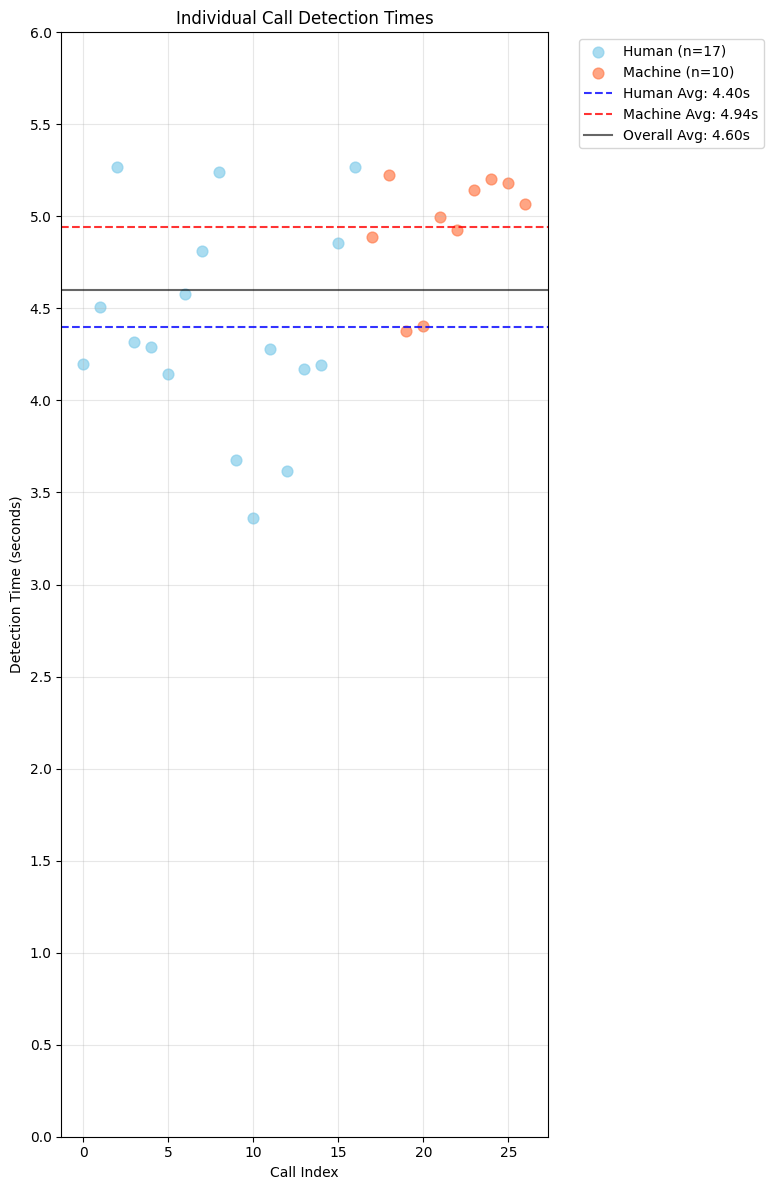

In [129]:
# scatterplot representation with compressed y-axis

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# plot style
plt.style.use('default')
sns.set_palette('husl')

# set filter to only records with detection intervals
df_detected = df[df['detection_interval_seconds'].notna()].copy()

# create the plot
fig = plt.figure(figsize=(20,12))
# main chart will be detection times by conversation
ax1 = plt.subplot(2, 3, (1, 4))

# scatter plot with different colors for human vs machine
human_data = df_detected[df_detected['detection_type'] == 'human']
machine_data = df_detected[df_detected['detection_type'] == 'machine']

# plot points
if len(human_data) > 0:
    ax1.scatter(range(len(human_data)), human_data['detection_interval_seconds'], 
               alpha=0.7, s=60, label=f'Human (n={len(human_data)})', color='skyblue')

if len(machine_data) > 0:
    ax1.scatter(range(len(human_data), len(human_data) + len(machine_data)), 
               machine_data['detection_interval_seconds'],
               alpha=0.7, s=60, label=f'Machine (n={len(machine_data)})', color='coral')

# Add average lines
if len(human_data) > 0:
    human_avg = human_data['detection_interval_seconds'].mean()
    ax1.axhline(y=human_avg, color='blue', linestyle='--', alpha=0.8, 
               label=f'Human Avg: {human_avg:.2f}s')

if len(machine_data) > 0:
    machine_avg = machine_data['detection_interval_seconds'].mean()
    ax1.axhline(y=machine_avg, color='red', linestyle='--', alpha=0.8,
               label=f'Machine Avg: {machine_avg:.2f}s')

overall_avg = df_detected['detection_interval_seconds'].mean()
ax1.axhline(y=overall_avg, color='black', linestyle='-', alpha=0.6,
           label=f'Overall Avg: {overall_avg:.2f}s')

# Set clean y-axis limits for data maxing at 5.25 seconds
ax1.set_ylim(0, 6)  # Clean limit at 6 seconds with nice spacing

# Optional: Set nice y-axis tick marks
ax1.set_yticks(np.arange(0, 6.5, 0.5))  # Tick marks every 0.5 seconds

ax1.set_xlabel('Call Index')
ax1.set_ylabel('Detection Time (seconds)')
ax1.set_title('Individual Call Detection Times')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

print(f"Y-axis range: 0 to 6 seconds")
print(f"Data range: {df_detected['detection_interval_seconds'].min():.1f} to {df_detected['detection_interval_seconds'].max():.1f} seconds")

plt.tight_layout()

# Export as JPG
plt.savefig('detection_times_scatter.jpg', 
            dpi=300,           # High resolution
            bbox_inches='tight', # Tight bounding box
            facecolor='white',   # White background
            edgecolor='none',    # No border
            format='jpg')

# Also save as PNG for better quality (optional)
plt.savefig('detection_times_scatter.png', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white',
            edgecolor='none',
            format='png')

print("✅ Charts saved as:")
print("   - detection_times_scatter.jpg")
print("   - detection_times_scatter.png")

plt.show()

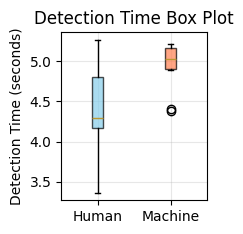

In [123]:
# boxplot representation
ax3 = plt.subplot(2, 3, 3)
detection_data = []
detection_labels = []
if len(human_data) > 0:
    detection_data.append(human_data['detection_interval_seconds'])
    detection_labels.append('Human')
if len(machine_data) > 0:
    detection_data.append(machine_data['detection_interval_seconds'])
    detection_labels.append('Machine')

if detection_data:
    bp = ax3.boxplot(detection_data, tick_labels=detection_labels, patch_artist=True)
    colors = ['skyblue', 'coral']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax3.set_ylabel('Detection Time (seconds)')
ax3.set_title('Detection Time Box Plot')
ax3.grid(True, alpha=0.3)

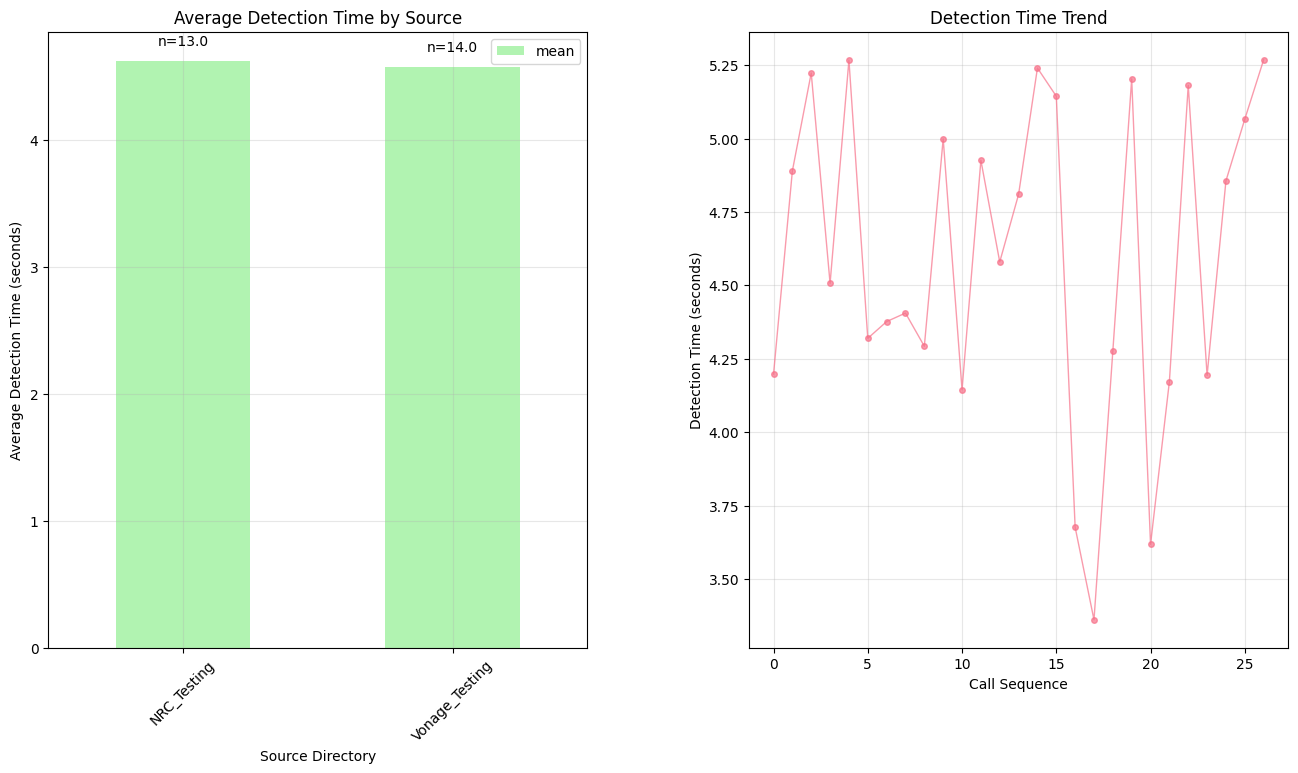

In [124]:
# comparison of Vonage subject results versus NRC subject results:
# Option 3: Keep subplots but with better spacing
fig = plt.figure(figsize=(16, 8))  # Wider figure, less tall

# Use a simpler 1x2 layout instead of 2x3
ax1 = plt.subplot(1, 2, 1)
source_stats = df_detected.groupby('source_directory')['detection_interval_seconds'].agg(['mean', 'count'])
source_stats.plot(kind='bar', y='mean', ax=ax1, color='lightgreen', alpha=0.7)
ax1.set_xlabel('Source Directory')
ax1.set_ylabel('Average Detection Time (seconds)')
ax1.set_title('Average Detection Time by Source')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add count labels on bars
for i, (idx, row) in enumerate(source_stats.iterrows()):
    ax1.text(i, row['mean'] + 0.1, f"n={row['count']}", ha='center', va='bottom')

ax2 = plt.subplot(1, 2, 2)
if len(df_detected) > 1:
    df_sorted = df_detected.sort_index()
    ax2.plot(df_sorted.index, df_sorted['detection_interval_seconds'], 
             marker='o', alpha=0.7, linewidth=1, markersize=4)
    ax2.set_xlabel('Call Sequence')
    ax2.set_ylabel('Detection Time (seconds)')
    ax2.set_title('Detection Time Trend')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Insufficient data\nfor trend analysis', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Detection Time Trend')

plt.subplots_adjust(wspace=0.3)  # Add space between subplots
plt.show()


In [125]:
# final summary:

In [9]:
# Print summary statistics
# print("=== DETECTION TIME ANALYSIS ===")
# print(f"Total calls with detection: {len(df_detected)}")
# print(f"Human detections: {len(human_data)} ({len(human_data)/len(df_detected)*100:.1f}%)")
# print(f"Machine detections: {len(machine_data)} ({len(machine_data)/len(df_detected)*100:.1f}%)")
# print()
# 
# if len(human_data) > 0:
#     print(f"Human Detection Stats:")
#     print(f"  Average: {human_data['detection_interval_seconds'].mean():.2f}s")
#     print(f"  Median: {human_data['detection_interval_seconds'].median():.2f}s")
#     print(f"  Min: {human_data['detection_interval_seconds'].min():.2f}s")
#     print(f"  Max: {human_data['detection_interval_seconds'].max():.2f}s")
#     print()
# 
# if len(machine_data) > 0:
#     print(f"Machine Detection Stats:")
#     print(f"  Average: {machine_data['detection_interval_seconds'].mean():.2f}s")
#     print(f"  Median: {machine_data['detection_interval_seconds'].median():.2f}s")
#     print(f"  Min: {machine_data['detection_interval_seconds'].min():.2f}s")
#     print(f"  Max: {machine_data['detection_interval_seconds'].max():.2f}s")
#     print()
# 
# print(f"Overall Average Detection Time: {overall_avg:.2f}s")
# 
# # Show records with longest/shortest detection times
# print("\n=== EXTREME CASES ===")
# if len(df_detected) > 0:
#     fastest = df_detected.loc[df_detected['detection_interval_seconds'].idxmin()]
#     slowest = df_detected.loc[df_detected['detection_interval_seconds'].idxmax()]
#     
#     print(f"Fastest Detection: {fastest['detection_interval_seconds']:.2f}s")
#     print(f"  Conversation: {fastest['conversation_uuid']}")
#     print(f"  Type: {fastest['detection_type']}")
#     print(f"  Source: {fastest['source_directory']}")
#     
#     print(f"\nSlowest Detection: {slowest['detection_interval_seconds']:.2f}s")
#     print(f"  Conversation: {slowest['conversation_uuid']}")
#     print(f"  Type: {slowest['detection_type']}")
#     print(f"  Source: {slowest['source_directory']}")

In [10]:
# Find the longest machine detection time
# longest_machine = machine_data.loc[machine_data['detection_interval_seconds'].idxmax()]
# 
# print("=== LONGEST MACHINE DETECTION ===")
# print(f"Detection Time: {longest_machine['detection_interval_seconds']:.2f}s")
# print(f"Conversation UUID: {longest_machine['conversation_uuid']}")
# print(f"Source Directory: {longest_machine['source_directory']}")
# print(f"Source File: {longest_machine['source_file']}")
# print(f"Phone Numbers: {longest_machine['from']} → {longest_machine['to']}")
# print(f"Status Sequence: {longest_machine['status_sequence']}")
# print(f"Sub-states: {longest_machine['sub_states']}")

In [11]:
# def display_detection_times_by_directory():
#     """Display detection times for each conversation organized by source directory"""
#     
#     # Get all records with detection times
#     df_detected = df[df['detection_interval_seconds'].notna()].copy()
#     
#     print("="*80)
#     print("DETECTION TIME SUMMARY BY CONVERSATION")
#     print("="*80)
#     
#     # Group by source directory
#     for source_dir in df_detected['source_directory'].unique():
#         dir_data = df_detected[df_detected['source_directory'] == source_dir]
#         
#         print(f"\n📁 SOURCE DIRECTORY: {source_dir}")
#         print(f"   Total conversations: {len(dir_data)}")
#         print(f"   Average detection time: {dir_data['detection_interval_seconds'].mean():.2f}s")
#         print("-" * 80)
#         
#         # Group by source file within directory
#         for source_file in dir_data['source_file'].unique():
#             file_data = dir_data[dir_data['source_file'] == source_file]
#             
#             print(f"\n   📄 FILE: {source_file}")
#             print(f"      Conversations in file: {len(file_data)}")
#             print(f"      File average detection: {file_data['detection_interval_seconds'].mean():.2f}s")
#             print("      " + "-" * 60)
#             
#             # Show each conversation in the file
#             for idx, row in file_data.iterrows():
#                 detection_time = row['detection_interval_seconds']
#                 detection_type = row['detection_type']
#                 conv_uuid = row['conversation_uuid']
#                 from_num = row['from']
#                 to_num = row['to']
#                 
#                 # Create status indicators
#                 type_icon = "👤" if detection_type == "human" else "🤖"
#                 speed_icon = "🚀" if detection_time < 3 else "⚡" if detection_time < 6 else "🐌"
#                 
#                 print(f"      {type_icon} {detection_type.upper():<8} | "
#                       f"{speed_icon} {detection_time:6.2f}s | "
#                       f"{from_num} → {to_num} | "
#                       f"{conv_uuid}")
#             
#             print()
#     
#     print("="*80)
#     
#     # Summary table by file
#     print("\n📊 SUMMARY TABLE BY FILE")
#     print("="*80)
#     
#     file_summary = df_detected.groupby(['source_directory', 'source_file']).agg({
#         'detection_interval_seconds': ['count', 'mean', 'min', 'max', 'std'],
#         'detection_type': lambda x: f"H:{sum(x=='human')} M:{sum(x=='machine')}"
#     }).round(2)
#     
#     # Flatten column names
#     file_summary.columns = ['Count', 'Avg_Time', 'Min_Time', 'Max_Time', 'Std_Dev', 'H_M_Split']
#     
#     print(file_summary.to_string())
#     
#     return file_summary
# 
# def display_fastest_slowest_by_directory():
#     """Show fastest and slowest detections in each directory"""
#     
#     df_detected = df[df['detection_interval_seconds'].notna()].copy()
#     
#     print("\n" + "="*80)
#     print("🏆 FASTEST & SLOWEST DETECTIONS BY DIRECTORY")
#     print("="*80)
#     
#     for source_dir in df_detected['source_directory'].unique():
#         dir_data = df_detected[df_detected['source_directory'] == source_dir]
#         
#         fastest = dir_data.loc[dir_data['detection_interval_seconds'].idxmin()]
#         slowest = dir_data.loc[dir_data['detection_interval_seconds'].idxmax()]
#         
#         print(f"\n📁 {source_dir}")
#         print(f"   🚀 FASTEST: {fastest['detection_interval_seconds']:.2f}s "
#               f"({fastest['detection_type']}) in {fastest['source_file']}")
#         print(f"      UUID: {fastest['conversation_uuid']}")
#         
#         print(f"   🐌 SLOWEST: {slowest['detection_interval_seconds']:.2f}s "
#               f"({slowest['detection_type']}) in {slowest['source_file']}")
#         print(f"      UUID: {slowest['conversation_uuid']}")
# 
# def create_detection_dataframe():
#     """Create a clean DataFrame for further analysis"""
#     
#     df_detected = df[df['detection_interval_seconds'].notna()].copy()
#     
#     # Select relevant columns and create a clean summary
#     summary_df = df_detected[[
#         'conversation_uuid', 'source_directory', 'source_file',
#         'detection_type', 'detection_interval_seconds',
#         'from', 'to', 'status_sequence', 'sub_states'
#     ]].copy()
#     
#     # Add some useful derived columns
#     summary_df['speed_category'] = pd.cut(
#         summary_df['detection_interval_seconds'], 
#         bins=[0, 3, 6, float('inf')], 
#         labels=['Fast (<3s)', 'Medium (3-6s)', 'Slow (>6s)']
#     )
#     
#     # Sort by detection time
#     summary_df = summary_df.sort_values('detection_interval_seconds')
#     
#     return summary_df
# 
# # Run the analysis
# print("Running detection time analysis...")
# file_summary = display_detection_times_by_directory()
# display_fastest_slowest_by_directory()
# 
# print("\n" + "="*80)
# print("📋 CREATING CLEAN SUMMARY DATAFRAME")
# print("="*80)
# 
# summary_df = create_detection_dataframe()
# print(f"Created summary DataFrame with {len(summary_df)} conversations")
# print(f"Columns: {list(summary_df.columns)}")
# 
# # Show first few rows
# print("\nFirst 10 conversations (sorted by detection time):")
# print(summary_df[['conversation_uuid', 'source_directory', 'source_file', 
#                   'detection_type', 'detection_interval_seconds', 'speed_category']].head(10).to_string())
# 
# print(f"\nSpeed distribution:")
# print(summary_df['speed_category'].value_counts())
# 
# # Store the summary for further use
# print(f"\n✅ Summary DataFrame stored as 'summary_df' for further analysis")